# Exploratory Data Analysis


In [36]:
#Imports
import gdown
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#=========================================== DATA LOADING ===========================================

In [3]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
DATA_FOLDER = ROOT_FOLDER + "/data/"

LINKS_CSV = 'links.csv'
MOVIES_CSV = 'movies.csv'
RATINGS_CSV = 'ratings.csv'
TAGS_CSV = 'tags.csv'

data_links = 'https://drive.google.com/uc?id=19cRdbSbDD4lnKAbv6nfwppRXL7kko6HT'
data_movies = 'https://drive.google.com/uc?id=14s8JDudJHGirQT3VYFwp18JBwSX3liYZ'
data_ratings = 'https://drive.google.com/uc?id=1hYYWUHk5hrDsCdj4BJG0UXBhQ_-AiZWO'
data_tags = 'https://drive.google.com/uc?id=1y7px4xin3_9KBvdAnmiz_uH0uBtPo-hH'

In [4]:
def download_from_drive(url, output_filename):
    output_filepath = DATA_FOLDER + output_filename
    if not os.path.isfile(output_filepath):
        gdown.download(url, output_filepath, quiet=True)

def read_csv_to_df(filename):
    return pd.read_csv(DATA_FOLDER + filename)

def load_data():
    # Download the dataset from the google drive so as to avoid large files in github.
    download_from_drive(data_links, LINKS_CSV)
    download_from_drive(data_movies, MOVIES_CSV)
    download_from_drive(data_ratings, RATINGS_CSV)
    download_from_drive(data_tags, TAGS_CSV)

    # Read date files from spark context
    links_df = read_csv_to_df(LINKS_CSV)
    movies_df = read_csv_to_df(MOVIES_CSV)
    ratings_df = read_csv_to_df(RATINGS_CSV)
    tags_df = read_csv_to_df(TAGS_CSV)

    return links_df, movies_df, ratings_df, tags_df

In [5]:
links_df, movies_df, ratings_df, tags_df = load_data()

In [6]:
#=========================================== View Sameple Data ===========================================

In [7]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [11]:
#=========================================== Distribution by genre ===========================================

<AxesSubplot:>

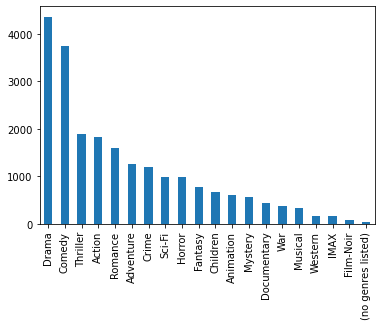

In [12]:
movies_df.genres.str.get_dummies('|').sum().sort_values(ascending=False).plot(kind='bar')

Here as can be seen, Drama and Comendy are highest produced movies.

In [13]:
#=========================================== Distribution by genre and ratings===========================================

In [14]:
movie_ratings_df = ratings_df.merge(movies_df, on=['movieId'], how='left')
movie_ratings_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [15]:
generes_df = (movie_ratings_df.genres.str.split('|', expand=True)
                  .stack()
                  .reset_index(drop=True, level=1)
                  .rename('genres'))
movie_ratings_genres_df = ratings_df.join(generes_df)
movie_ratings_genres_df.head(10)

,userId,movieId,rating,timestamp,genres
0,1,1,4.0,964982703,Adventure
0,1,1,4.0,964982703,Animation
0,1,1,4.0,964982703,Children
0,1,1,4.0,964982703,Comedy
0,1,1,4.0,964982703,Fantasy
1,1,3,4.0,964981247,Comedy
1,1,3,4.0,964981247,Romance
2,1,6,4.0,964982224,Action
2,1,6,4.0,964982224,Crime
2,1,6,4.0,964982224,Thriller


In [16]:
genres_wise_avg_ratings_df = movie_ratings_genres_df.groupby('genres')['rating'].mean().reset_index()
genres_wise_avg_ratings_df.sort_values(by='rating', ascending=False).head(10)

,genres,rating
10,Film-Noir,3.920115
18,War,3.808294
7,Documentary,3.797785
6,Crime,3.658294
8,Drama,3.656184
14,Mystery,3.632460
3,Animation,3.629937
12,IMAX,3.618335
19,Western,3.583938
13,Musical,3.563678


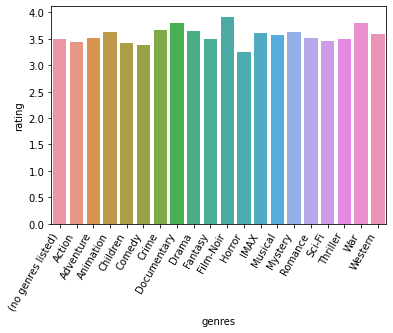

In [17]:
chart1 = sns.barplot(x='genres', y='rating', data=genres_wise_avg_ratings_df)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=60, horizontalalignment='right');


As it can been seen from the data, the generes 'Film-Noir', 'War' & 'Documentary' have the mostly rated movies on avergae.

In [18]:
#=========================================== Rating distribution across years ===========================================

In [19]:
movie_ratings_genres_df['year'] = pd.to_datetime(movie_ratings_genres_df['timestamp'], unit='s').dt.year
movie_ratings_genres_df

,userId,movieId,rating,timestamp,genres,year
0,1,1,4.0,964982703,Adventure,2000
0,1,1,4.0,964982703,Animation,2000
0,1,1,4.0,964982703,Children,2000
0,1,1,4.0,964982703,Comedy,2000
0,1,1,4.0,964982703,Fantasy,2000
...,...,...,...,...,...,...
100834,610,168252,5.0,1493846352,Sci-Fi,2017
100835,610,170875,3.0,1493846415,Action,2017
100835,610,170875,3.0,1493846415,Crime,2017
100835,610,170875,3.0,1493846415,Drama,2017


In [20]:
year_wise_genre_count_df = movie_ratings_genres_df.groupby(['year', 'genres'])['movieId'].nunique().to_frame(name='movie_count').reset_index()
year_wise_genre_count_df

,year,genres,movie_count
0,1996,Action,123
1,1996,Adventure,103
2,1996,Animation,30
3,1996,Children,86
4,1996,Comedy,229
...,...,...,...
435,2018,Romance,483
436,2018,Sci-Fi,490
437,2018,Thriller,606
438,2018,War,100


In [21]:
year_wise_genre_count_df['avg_rating'] = movie_ratings_genres_df.groupby(['year', 'genres'])[['rating']].mean().reset_index().rating
year_wise_genre_count_df

,year,genres,movie_count,avg_rating
0,1996,Action,123,3.434318
1,1996,Adventure,103,3.503770
2,1996,Animation,30,3.753501
3,1996,Children,86,3.567143
4,1996,Comedy,229,3.425333
...,...,...,...,...
435,2018,Romance,483,3.340474
436,2018,Sci-Fi,490,3.375000
437,2018,Thriller,606,3.436129
438,2018,War,100,3.572368


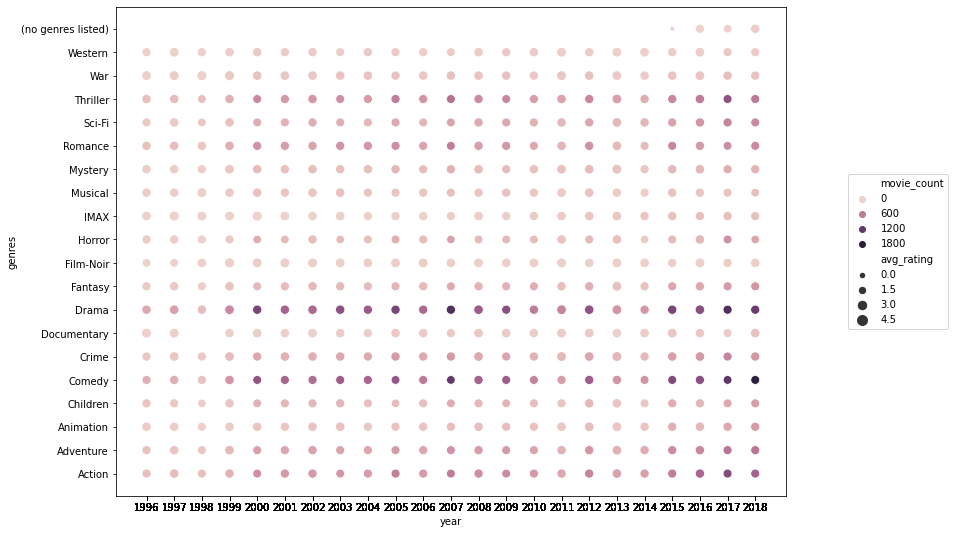

In [50]:
plt.figure(figsize=(12,9))
sns.scatterplot(x = 'year', 
                y='genres', 
                hue='movie_count', 
                size='avg_rating', sizes=(20,100),
                data=year_wise_genre_count_df).legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xticks(year_wise_genre_count_df['year'])
plt.show()

As can be inferred from the data, in the years 2007, 2009 and 2015-2018 ratings for Drama and Comedy were high in numbers and also rating at good ratings.